# Analyzing New York City employees' payroll database 

## Data Source: [NYC open data](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e/data)

In [1]:
import pandas as pd
from plotnine import *
df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.lower()
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [8]:
df.query("first_name.isna() and agency_name=='POLICE DEPARTMENT' and fiscal_year==2021 and work_location_borough=='MANHATTAN'")

fiscal_year  payroll_number        agency_name last_name first_name  \
2291075         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2291168         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2291311         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2291471         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2291473         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
...              ...             ...                ...       ...        ...   
2864116         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2864424         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2864489         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2864512         2021           56.00  POLICE DEPARTMENT       NaN        NaN   
2864520         2021           56.00  POLICE DEPARTMENT       NaN        NaN   

        mid_init agency_start_date work_location_borough  \
2291075      NaN        07/16/1984             MANHATTAN   
2291168      NaN        07/03/1989             MANHATTAN   
2291311      NaN        01/26/1981             MANHATTAN   
2291471      NaN        01/26/1982             MANHATTAN   
2291473      NaN        07/05/1989             MANHATTAN   
...          ...               ...                   ...   
2864116      NaN        01/03/1983             MANHATTAN   
2864424      NaN        04/30/1995             MANHATTAN   
2864489      NaN        08/31/1998             MANHATTAN   
2864512      NaN        07/26/1991             MANHATTAN   
2864520      NaN        04/02/1995             MANHATTAN   

                                    title_description  \
2291075         CAPTAIN DETAILED AS CHIEF OF TRAINING   
2291168  CAPTAIN DETAILED AS CHIEF OF RISK MANAGEMENT   
2291311             LIEUTENANT D/A SPECIAL ASSIGNMENT   
2291471  CAPTAIN DETAILED AS CHIEF OF LABOR RELATIONS   
2291473   LIEUTENANT D/A COMMANDER OF DETECTIVE SQUAD   
...                                               ...   
2864116                                POLICE OFFICER   
2864424                               P.O. DA DET GR3   
2864489                                     SERGEANT-   
2864512           POLICE OFFICER D/A DETECTIVE 2ND GR   
2864520           POLICE OFFICER D/A DETECTIVE 1ST GR   

        leave_status_as_of_june_30  base_salary  pay_basis  regular_hours  \
2291075                     CEASED   241,116.00  per Annum         400.00   
2291168                     CEASED   241,116.00  per Annum           0.00   
2291311                     CEASED   149,068.00  per Annum       1,991.48   
2291471                     CEASED   241,116.00  per Annum         354.30   
2291473                     CEASED   149,068.00  per Annum       2,122.08   
...                            ...          ...        ...            ...   
2864116                     CEASED    85,292.00  per Annum         -40.02   
2864424                     CEASED    97,324.00  per Annum           0.00   
2864489                     CEASED   109,360.00  per Annum           0.00   
2864512                     CEASED   109,360.00  per Annum           0.00   
2864520                     CEASED   125,531.00  per Annum           0.00   

         regular_gross_paid  ot_hours  total_ot_paid  total_other_pay  
2291075           46,222.47      0.00           0.00       312,126.91  
2291168                0.00      0.00           0.00       272,732.17  
2291311          140,837.46  1,028.33      85,055.91        20,811.55  
2291471           40,939.90      0.00           0.00       195,627.65  
2291473          150,480.23    860.17      55,532.99        30,462.81  
...                     ...       ...            ...              ...  
2864116           -1,631.36      0.00           0.00        -1,780.34  
2864424                0.00      0.00           0.00       -24,574.82  
2864489                0.00      0.00           0.00       -20,814.36

In [3]:
df.shape

(2864545, 17)

Previous versions of the dataset didn't import all the years correctly, so I'll do these sanity checks a couple of times

In [4]:
df.fiscal_year.value_counts()

2019    592431
2020    590210
2021    573477
2017    562266
2018    546161
Name: fiscal_year, dtype: int64

#### Cleaning the data

The database includes people whose work locations are outside of NYC. For this analyses, I'm only including employees with work locations in NYC boroughs. Since Staten Island wasn't listed (unless included in the "other" location, this is filtered down to Queens, Manhattan, Bronx and Brooklyn.

In [9]:
boroughs = ['QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']

In [10]:
df = df[df.work_location_borough.isin(boroughs)]

In [11]:
df.shape

(2760682, 17)

Note: This reduced the dataset by 103,863 rows.

### A note on the assumptions I'm making here on:

From our reporting, I found that some employees tend to work more overtime as they get closer to retirement. Let's take a closer look here on.

In [12]:
df['agency_start_date'] = pd.to_datetime(df.agency_start_date, errors='coerce')
df['today'] = pd.to_datetime('today')
df['tenure_years'] = (df.today - df.agency_start_date).astype('timedelta64[Y]')

In [13]:
df.head(5)

fiscal_year  payroll_number                agency_name     last_name  \
0         2017             NaN  ADMIN FOR CHILDREN'S SVCS         AARON   
1         2017             NaN  ADMIN FOR CHILDREN'S SVCS        AARONS   
2         2017             NaN  ADMIN FOR CHILDREN'S SVCS         ABDUL   
3         2017             NaN  ADMIN FOR CHILDREN'S SVCS  ABDUL RAHMAN   
4         2017             NaN  ADMIN FOR CHILDREN'S SVCS   ABDULGANIYU   

   first_name mid_init agency_start_date work_location_borough  \
0      TERESA      NaN        2016-03-21                 BRONX   
1     CAMELIA        M        2016-08-08              BROOKLYN   
2      MODUPE      NaN        2008-02-11              BROOKLYN   
3  ABDUL AZIZ        I        2014-10-20             MANHATTAN   
4    MONSURAT        A        2013-02-04                 BRONX   

             title_description leave_status_as_of_june_30  base_salary  \
0  CHILD PROTECTIVE SPECIALIST                     ACTIVE    51,315.00   
1  CHILD PROTECTIVE SPECIALIST                     ACTIVE    51,315.00   
2  CHILD PROTECTIVE SPECIALIST                     ACTIVE    54,720.00   
3  CHILD PROTECTIVE SPECIALIST                     ACTIVE    54,720.00   
4           JUVENILE COUNSELOR                     ACTIVE    44,409.00   

   pay_basis  regular_hours  regular_gross_paid  ot_hours  total_ot_paid  \
0  per Annum       1,825.00           51,709.59    588.00      22,374.31   
1  per Annum       1,595.55           41,960.18    121.75       3,892.19   
2  per Annum       1,825.00           56,298.93     54.75       2,455.88   
3  per Annum       1,825.00           55,346.09    273.00      11,069.41   
4  per Annum       1,762.00           44,157.49    815.50      27,878.15   

   total_other_pay                      today  tenure_years  
0           639.66 2022-05-13 09:45:05.656237          6.00  
1           108.25 2022-05-13 09:45:05.656237          5.00  
2         3,938.75 2022-05-13 09:45:05.656237         14.00  
3         1,124.51 2022-05-13 09:45:05.656237          7.00  
4         2,019.34 2022-05-13 09:45:05.656237          9.00

In [14]:
df.agency_name.unique()

array(["ADMIN FOR CHILDREN'S SVCS", 'BOARD OF ELECTION',
       'BOARD OF ELECTION POLL WORKERS', 'ADMIN TRIALS AND HEARINGS',
       'CITY CLERK', 'BOARD OF CORRECTION', 'BOROUGH PRESIDENT-BRONX',
       'BOROUGH PRESIDENT-BROOKLYN', 'BOROUGH PRESIDENT-QUEENS',
       'BRONX COMMUNITY BOARD #1', 'BRONX COMMUNITY BOARD #10',
       'BRONX COMMUNITY BOARD #11', 'BRONX COMMUNITY BOARD #12',
       'BRONX COMMUNITY BOARD #2', 'BRONX COMMUNITY BOARD #3',
       'BRONX COMMUNITY BOARD #4', 'BRONX COMMUNITY BOARD #5',
       'BRONX COMMUNITY BOARD #6', 'BRONX COMMUNITY BOARD #7',
       'BRONX COMMUNITY BOARD #8', 'BRONX COMMUNITY BOARD #9',
       'BROOKLYN COMMUNITY BOARD #1', 'BROOKLYN COMMUNITY BOARD #10',
       'BROOKLYN COMMUNITY BOARD #11', 'BROOKLYN COMMUNITY BOARD #12',
       'BROOKLYN COMMUNITY BOARD #13', 'BROOKLYN COMMUNITY BOARD #14',
       'BROOKLYN COMMUNITY BOARD #15', 'BROOKLYN COMMUNITY BOARD #16',
       'BROOKLYN COMMUNITY BOARD #17', 'BROOKLYN COMMUNITY BOARD #18',
  

In [15]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df.query("agency_name=='FIRE DEPARTMENT'")

# title_description
# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ regular_hours + tenure_years', data=to_model) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     9722.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        09:45:53   Log-Likelihood:            -6.1571e+05
No. Observations:               89030   AIC:                         1.231e+06
Df Residuals:                   89027   BIC:                         1.231e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -83.5126      3.308    -25.248      0.000     -89.996     -77.030
regular_hours     0.2150      0.002    138.889      0.000       0.212       0.218
tenure_years      1.2800      0.087     14.683      0.000       1.109       1.451
==============================================================================
Omnibus:                     9325.106   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14261.406
Skew:                           0.781   Prob(JB):                         0.00
Kurtosis:                       4.184   Cond. No.                     7.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
to_model = df.query("agency_name=='POLICE DEPARTMENT'")

jobs = to_model.query('ot_hours > 0 and fiscal_year==2021 and work_location_borough=="MANHATTAN"')\
    .query('regular_hours > 0').title_description.value_counts().head(8).index.tolist()

jobs

['POLICE OFFICER',
 'SERGEANT-',
 'P.O. DA DET GR3',
 'TRAFFIC ENFORCEMENT AGENT',
 'SCHOOL SAFETY AGENT',
 'LIEUTENANT',
 'POLICE OFFICER D/A DETECTIVE 2ND GR',
 'P.O. DET SPEC']

/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 559 rows containing missing values.


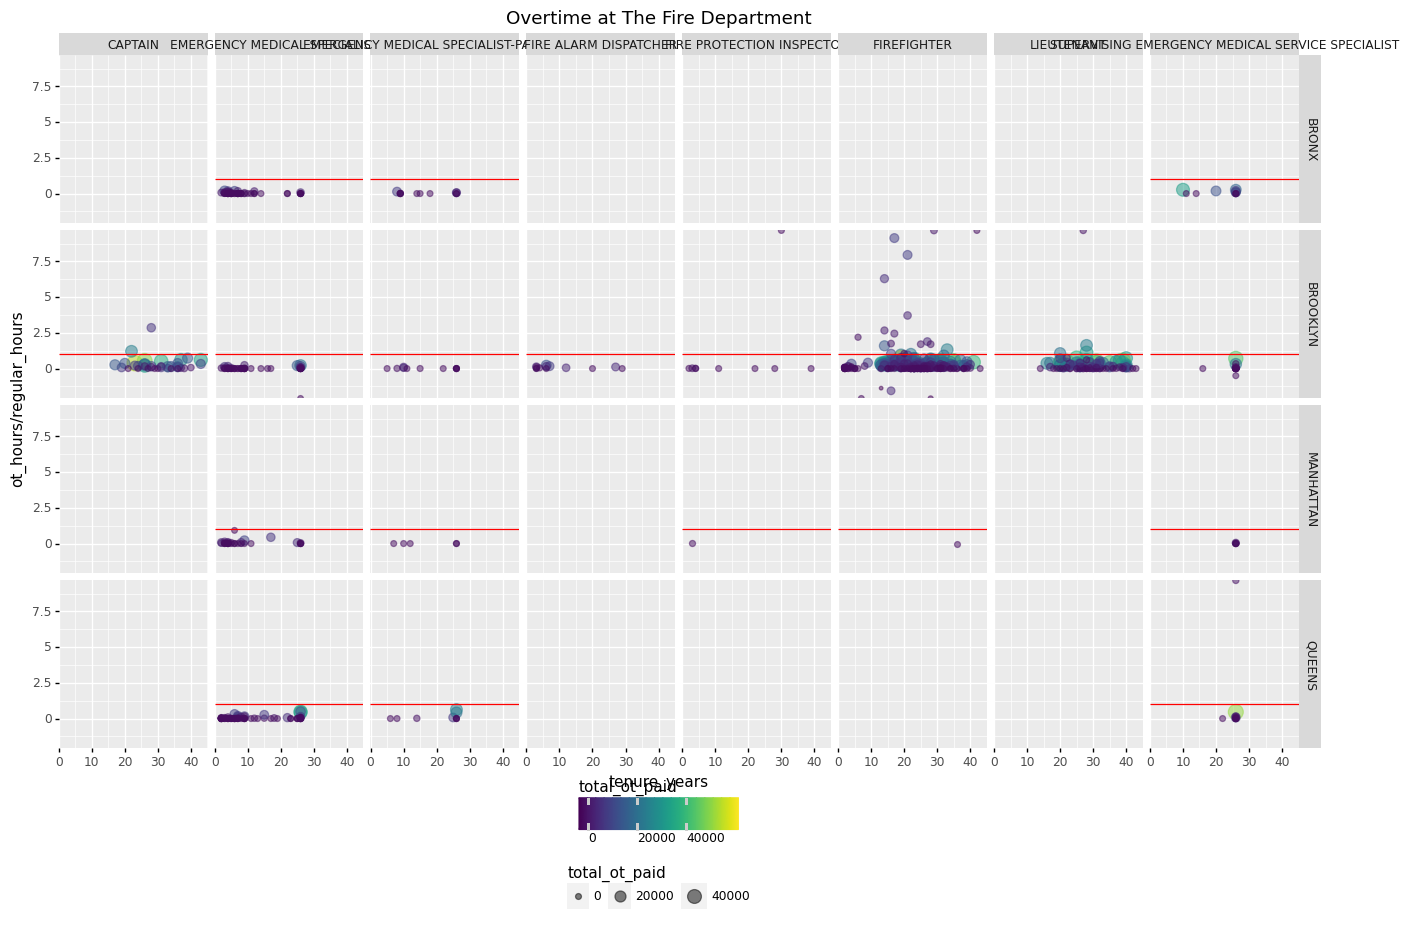

<ggplot: (820243173)>

In [134]:

(
    ggplot(to_model.query('fiscal_year==2020 and leave_status_as_of_june_30=="CEASED" and title_description.isin(@jobs)'), 
           aes(x='tenure_years', y='ot_hours/regular_hours', color='total_ot_paid', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('work_location_borough~title_description') +
#         scale_color_gradient(low='yellow',high='red') + 
        ggtitle('Overtime at The Fire Department') + 
        theme(figure_size=(16,9),
             legend_position='bottom')

)    

In [120]:
to_model.query('ot_hours / regular_hours > 10 and leave_status_as_of_june_30=="CEASED"')

fiscal_year  payroll_number      agency_name        last_name  \
437032          2017             NaN  FIRE DEPARTMENT            BURKE   
452293          2017             NaN  FIRE DEPARTMENT           TUCKER   
583460          2018           57.00  FIRE DEPARTMENT         ESPOSITO   
584301          2018           57.00  FIRE DEPARTMENT       DURNIN JR.   
1135465         2019           57.00  FIRE DEPARTMENT  VANDERLOFSKE II   
1783325         2020           57.00  FIRE DEPARTMENT             HOEY   
1783807         2020           57.00  FIRE DEPARTMENT          DARNAUD   
1784896         2020           57.00  FIRE DEPARTMENT          HASSECK   
1784954         2020           57.00  FIRE DEPARTMENT           FRASER   
1785059         2020           57.00  FIRE DEPARTMENT          ELLIOTT   
2643739         2021           57.00  FIRE DEPARTMENT           HARSCH   
2664550         2021           57.00  FIRE DEPARTMENT          MCCANTS   
2775939         2021           57.00  FIRE DEPARTMENT            DEANE   
2776734         2021           57.00  FIRE DEPARTMENT            MASSA   
2860801         2021           57.00  FIRE DEPARTMENT            DAVIS   
2864517         2021           57.00  FIRE DEPARTMENT      KALTENMEIER   

        first_name mid_init agency_start_date work_location_borough  \
437032     WILLIAM        O        1986-01-09              BROOKLYN   
452293      ROBERT        K        1994-10-23              BROOKLYN   
583460     GABRIEL      NaN        1990-01-21              BROOKLYN   
584301      DENNIS        C        1999-02-16              BROOKLYN   
1135465      FRANK        V        1999-05-09              BROOKLYN   
1783325     THOMAS        M        1979-05-19              BROOKLYN   
1783807     THOMAS        J        1994-07-17              BROOKLYN   
1784896    WILLIAM        R        1993-05-09              BROOKLYN   
1784954    CHARLES      NaN        1996-03-17                QUEENS   
1785059      ERWIN        D        1992-02-24              BROOKLYN   
2643739    MICHAEL        J        1999-11-14              BROOKLYN   
2664550       SEAN        D        2008-07-01              BROOKLYN   
2775939    MICHAEL        J        2002-09-24              BROOKLYN   
2776734    RICHARD      NaN        1994-07-17              BROOKLYN   
2860801    ASHANTI        L        2000-09-29             MANHATTAN   
2864517       JOHN        W        1987-09-14              BROOKLYN   

                                        title_description  \
437032                                        FIREFIGHTER   
452293                                        FIREFIGHTER   
583460                                        FIREFIGHTER   
584301                                        FIREFIGHTER   
1135465                                       FIREFIGHTER   
1783325                                       FIREFIGHTER   
1783807                                        LIEUTENANT   
1784896                                       FIREFIGHTER   
1784954  SUPERVISING EMERGENCY MEDICAL SERVICE SPECIALIST   
1785059                         FIRE PROTECTION INSPECTOR   
2643739                                       FIREFIGHTER   
2664550                                       FIREFIGHTER   
2775939                                       FIREFIGHTER   
2776734                                       FIREFIGHTER   
2860801                  EMERGENCY MEDICAL SPECIALIST-EMT   
2864517                                       FIREFIGHTER   

        leave_status_as_of_june_30  base_salary  pay_basis  regular_hours  \
437032                      CEASED    82,808.00  per Annum           0.00   
452293                      CEASED    82,808.00  per Annum           0.00   
583460                      CEASED    85,292.00  per Annum           0.00   
584301                      CEASED    85,292.00  per Annum           0.00   
1135465                     CEASED    85,292.00  per Annum           0.00   
1783325                     CEASED    85,2

In [109]:
to_model['last_name_nan'] = to_model.last_name.isna()
to_model.value_counts(['last_name_nan', 'fiscal_year'])

/var/folders/fb/4mqgs_t92c99xgv1z3ql1q6w0000gp/T/ipykernel_31627/2286291479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


last_name_nan  fiscal_year
False          2020           18188
               2021           18089
               2019           17701
               2017           17661
               2018           17391
dtype: int64

In [121]:
to_model = to_model.query('ot_hours > 0 and fiscal_year==2021 and work_location_borough=="MANHATTAN"')\
               .query('regular_hours > 0')\
               .query('title_description.isin(@jobs)')

to_model

fiscal_year  payroll_number      agency_name  last_name   first_name  \
2291218         2021           57.00  FIRE DEPARTMENT     MORRIS       ROBERT   
2291236         2021           57.00  FIRE DEPARTMENT   BERTUCCI      DOMINIC   
2291239         2021           57.00  FIRE DEPARTMENT     HANSEN         JOHN   
2291289         2021           57.00  FIRE DEPARTMENT    GAFFNEY      MICHAEL   
2291303         2021           57.00  FIRE DEPARTMENT   CERIELLO         JOHN   
...              ...             ...              ...        ...          ...   
2686606         2021           57.00  FIRE DEPARTMENT     GEORGE        PETER   
2686925         2021           57.00  FIRE DEPARTMENT   APARICIO        JAIME   
2686926         2021           57.00  FIRE DEPARTMENT  KARCINSKI       THOMAS   
2686927         2021           57.00  FIRE DEPARTMENT   O'MALLEY        CONOR   
2687543         2021           57.00  FIRE DEPARTMENT    KOCOVIC  CHRISTOPHER   

        mid_init agency_start_date work_location_borough title_description  \
2291218        R        1995-07-09             MANHATTAN           CAPTAIN   
2291236      NaN        1995-10-15             MANHATTAN           CAPTAIN   
2291239        M        1995-07-09             MANHATTAN           CAPTAIN   
2291289        J        1994-07-17             MANHATTAN           CAPTAIN   
2291303        P        1988-02-18             MANHATTAN           CAPTAIN   
...          ...               ...                   ...               ...   
2686606        A        2021-05-10             MANHATTAN       FIREFIGHTER   
2686925        A        2021-05-10             MANHATTAN       FIREFIGHTER   
2686926        F        2021-05-10             MANHATTAN       FIREFIGHTER   
2686927        L        2021-05-10             MANHATTAN       FIREFIGHTER   
2687543        P        2021-05-10             MANHATTAN       FIREFIGHTER   

        leave_status_as_of_june_30  base_salary  pay_basis  regular_hours  \
2291218                     ACTIVE   135,511.00  per Annum       2,080.00   
2291236                     ACTIVE   135,511.00  per Annum       2,080.00   
2291239                     ACTIVE   135,511.00  per Annum       2,080.00   
2291289                     ACTIVE   135,511.00  per Annum       2,080.00   
2291303                     ACTIVE   135,511.00  per Annum       2,080.00   
...                            ...          ...        ...            ...   
2686606                     ACTIVE    43,904.00  per Annum         240.00   
2686925                     ACTIVE    43,904.00  per Annum         240.00   
2686926                     ACTIVE    43,904.00  per Annum         240.00   
2686927                     ACTIVE    43,904.00  per Annum         240.00   
2687543                     ACTIVE    43,904.00  per Annum         240.00   

         regular_gross_paid  ot_hours  total_ot_paid  total_other_pay  \
2291218          146,527.13    846.12      78,077.87        35,047.48   
2291236          146,527.13    803.52      74,955.15        35,125.78   
2291239          146,527.13    976.82      77,728.43        31,919.92   
2291289          146,527.13  1,099.92      87,240.46        15,497.54   
2291303          146,527.13    789.65      72,801.06        28,171.61   
...                     ...       ...            ...              ...   
2686606            5,051.97     14.00         441.56             0.00   
2686925            5,051.97     13.00         410.02             0.00   
2686926            5,051.97     13.00         410.02             0.00   
2686927            5,051.97     13.00         410.02             0.00   
2687543            5,051.97     11.00         346.94             0.00   

                             today  tenure_years  
2291218 2022-05-12 16:31:03.966740         26.00  
2291236 2022-05-12 16:31:03.966740         26.00  
2291239 2022-05-12 16:31:03.966740         26.00  
2291289 2022-05-12 16:31:03.966740         27.00  
2291303 2022-05-12 16:31:03.966740        

In [122]:
to_model.query("ot_hours/regular_hours > 1").to_csv('ot_rt_gt_1.csv')

/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


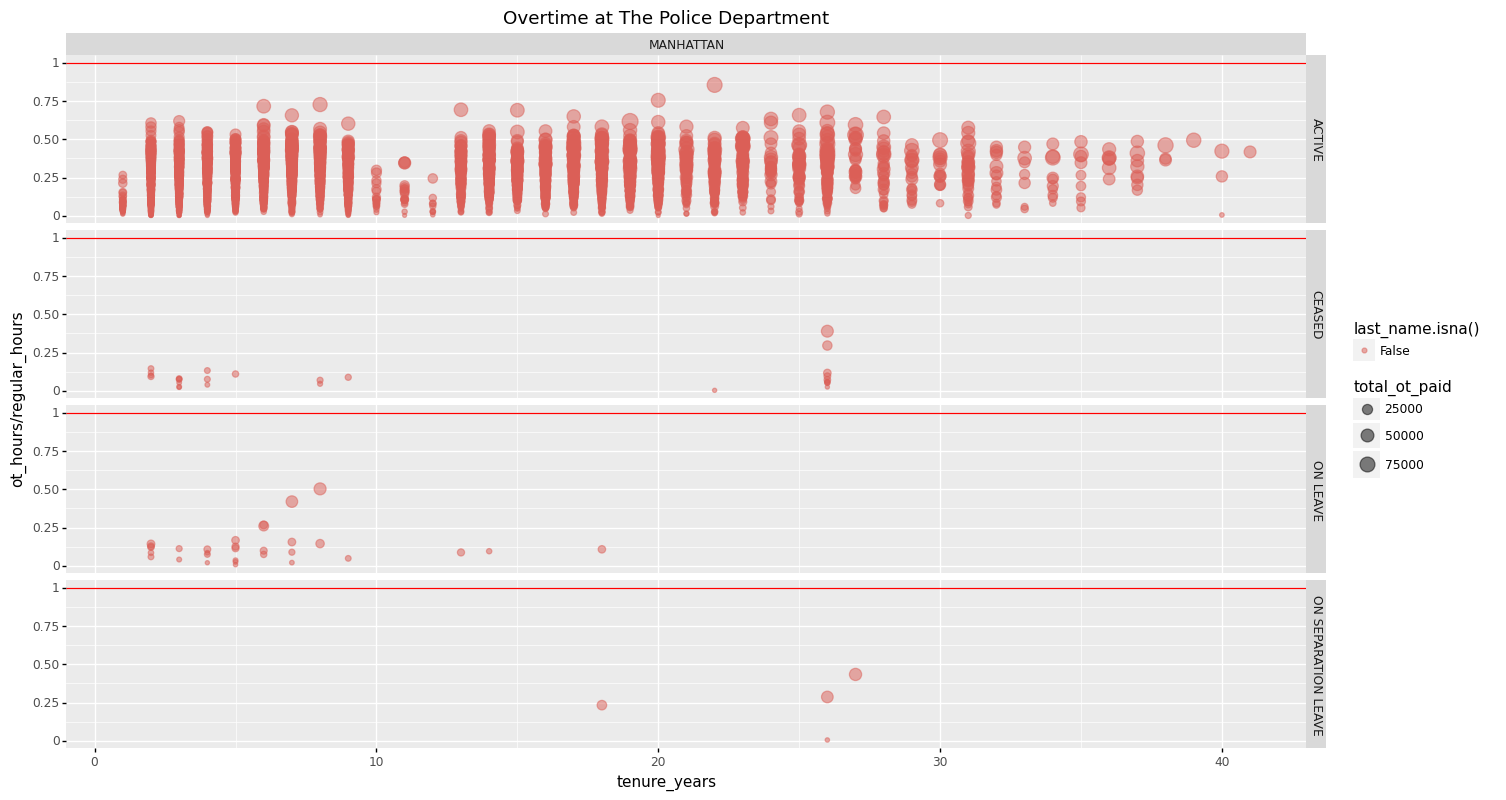

<ggplot: (377142083)>

In [123]:

(
    ggplot(to_model, 
           aes(x='tenure_years', y='ot_hours/regular_hours', color='last_name.isna()', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('leave_status_as_of_june_30~work_location_borough') +
#         scale_color_gradient(low='yellow',high='red') + 
        ggtitle('Overtime at The Police Department') + 
        theme(figure_size=(16,9))

)    

/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 11620 rows containing missing values.


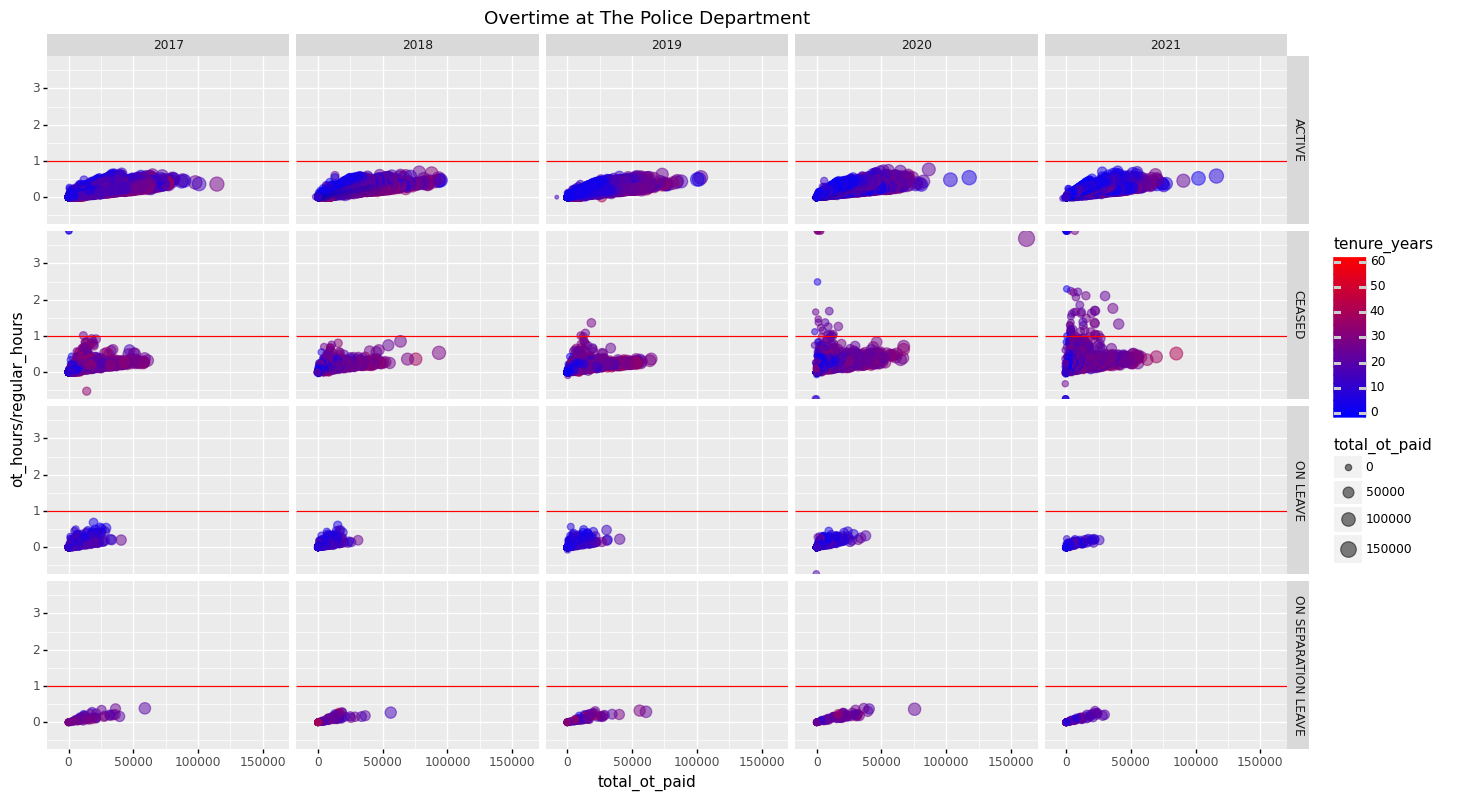

<ggplot: (879133639)>

In [140]:

(
    ggplot(to_model, 
           aes(x='total_ot_paid', y='ot_hours/regular_hours', color='tenure_years', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('leave_status_as_of_june_30~fiscal_year') +
        scale_color_gradient(low='blue',high='red') + 
        ggtitle('Overtime at The Police Department') + 
        theme(figure_size=(16,9))

)    

In [ ]:

(
    ggplot(to_model, 
           aes(x='tenure_years', y='ot_hours/regular_hours', color='total_ot_paid', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('leave_status_as_of_june_30~title_description') +
#         scale_color_gradient(low='yellow',high='red') + 
        ggtitle('Overtime at The Police Department') + 
        theme(figure_size=(16,9))

)    

In [86]:
to_model

fiscal_year  payroll_number        agency_name        last_name  \
1640901         2019           56.00  POLICE DEPARTMENT            MAMUN   
1640903         2019           56.00  POLICE DEPARTMENT           LEKHAK   
1640904         2019           56.00  POLICE DEPARTMENT          ODUWOLE   
1640905         2019           56.00  POLICE DEPARTMENT     DOWNING-KOHN   
1640907         2019           56.00  POLICE DEPARTMENT           HEBERT   
...              ...             ...                ...              ...   
1700843         2019           56.00  POLICE DEPARTMENT           BASHAR   
1700847         2019           56.00  POLICE DEPARTMENT  WILLIAMS GORDON   
1700849         2019           56.00  POLICE DEPARTMENT            ISLAM   
1700851         2019           56.00  POLICE DEPARTMENT           JALLIM   
1700853         2019           56.00  POLICE DEPARTMENT     LUNGAYAN JR.   

           first_name mid_init agency_start_date work_location_borough  \
1640901      ABDULLAH        A        2017-09-25             MANHATTAN   
1640903     TRIBHUWAN      NaN        2017-09-25             MANHATTAN   
1640904       ADEBOLA        O        2018-06-18             MANHATTAN   
1640905         SUSAN        E        1998-08-31             MANHATTAN   
1640907        JARROD        B        2005-07-12             MANHATTAN   
...               ...      ...               ...                   ...   
1700843            MD        F        2017-09-25             MANHATTAN   
1700847          GINA        V        2019-01-23             MANHATTAN   
1700849  A B M KAMRUL      NaN        2017-05-31             MANHATTAN   
1700851        ALISEN      NaN        2018-01-16             MANHATTAN   
1700853        HERMAN        V        2014-05-28             MANHATTAN   

                               title_description leave_status_as_of_june_30  \
1640901  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1640903  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1640904  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1640905                                SERGEANT-                     CEASED   
1640907                           POLICE OFFICER                     ACTIVE   
...                                          ...                        ...   
1700843  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1700847                      SCHOOL SAFETY AGENT                     ACTIVE   
1700849  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1700851  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   
1700853  TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY                     ACTIVE   

         base_salary  pay_basis  regular_hours  regular_gross_paid  ot_hours  \
1640901    38,986.00  per Annum       2,040.00           38,702.16    435.50   
1640903    38,986.00  per Annum       2,040.00           38,702.16    615.50   
1640904    38,986.00  per Annum       2,032.00           39,117.78    349.50   
1640905   109,360.00  per Annum         354.32           40,338.51     85.50   
1640907    85,292.00  per Annum       2,040.00           85,058.23    251.77   
...              ...        ...            ...                 ...       ...   
1700843    38,986.00  per Annum       2,040.00           38,709.20    422.75   
1700847    32,426.00  per Annum         801.15           13,432.50     27.50   
1700849    38,986.00  per Annum       2,040.00           39,447.39    717.75   
1700851    38,986.00  per Annum       2,040.00           38,673.46    172.25   
1700853    39,449.00  per Annum       2,040.00           39,032.61    306.50   

         total_ot_paid  total_other_pay                      today  \
1640901      13,119.41         1,198.16 2022-05-12 16:31:03.966740   
1640903      18,006.87           881.99 2022-05-12 16:31:03.966740   
1640904       9,732.59         1,418.46 2022-05-12 16:31:03.966740   
1640905       8,7

/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/homebrew/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


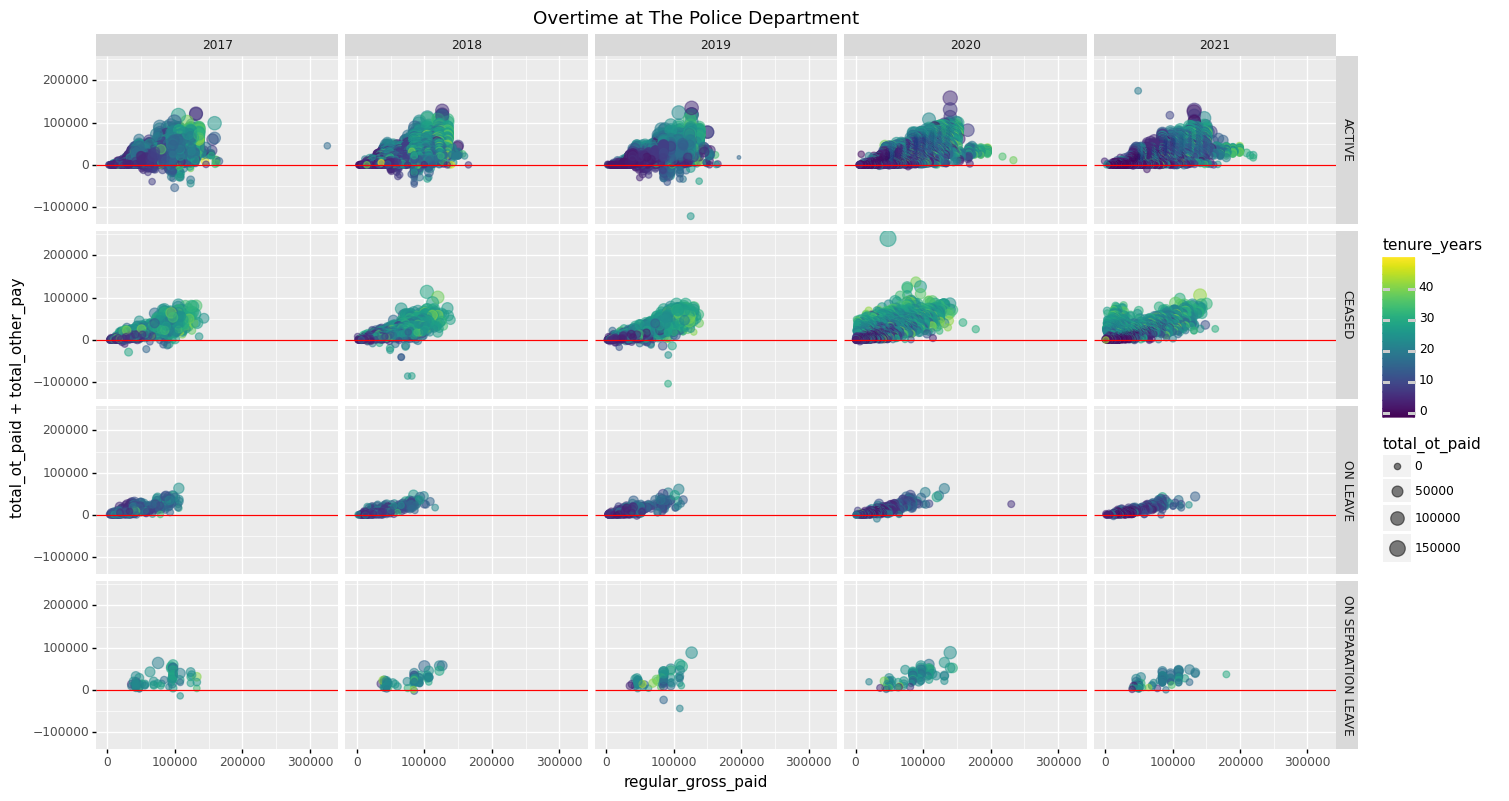

<ggplot: (375948761)>

In [53]:
(
    ggplot(to_model.query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='regular_gross_paid', y='total_ot_paid + total_other_pay', color='tenure_years', size='total_ot_paid')) +
        geom_point(alpha=.5) +
        geom_hline(aes(yintercept=1), color='red') + 
        facet_grid('leave_status_as_of_june_30~fiscal_year') +
#         scale_color_gradient(low='yellow',high='red') + 
        ggtitle('Overtime at The Police Department') + 
        theme(figure_size=(16,9))

)    

In [40]:
df.query('ot_hours/regular_hours > 5')

fiscal_year  payroll_number                    agency_name  \
74907           2017             NaN  COMMUNITY COLLEGE (MANHATTAN)   
437032          2017             NaN                FIRE DEPARTMENT   
452293          2017             NaN                FIRE DEPARTMENT   
529945          2017             NaN              POLICE DEPARTMENT   
558886          2017             NaN              POLICE DEPARTMENT   
...              ...             ...                            ...   
2861544         2021          740.00  DEPARTMENT OF EDUCATION ADMIN   
2861667         2021          841.00   DEPARTMENT OF TRANSPORTATION   
2861939         2021           56.00              POLICE DEPARTMENT   
2862081         2021           56.00              POLICE DEPARTMENT   
2864517         2021           57.00                FIRE DEPARTMENT   

           last_name first_name mid_init agency_start_date  \
74907          GARAY       LUIS      NaN        2009-02-02   
437032         BURKE    WILLIAM        O        1986-01-09   
452293        TUCKER     ROBERT        K        1994-10-23   
529945         KUNDU     GOUTAM      NaN        2016-07-25   
558886       WALDRON    MICHAEL        G        2015-01-07   
...              ...        ...      ...               ...   
2861544       TRAHAN    SHAMIKA        E        2019-06-16   
2861667     MCCARTHY      DAVID        M        1988-08-29   
2861939    RIVERA JR      DAVID      NaN        2020-03-23   
2862081       GIBSON   JEREMIAH        E        2020-03-24   
2864517  KALTENMEIER       JOHN        W        1987-09-14   

        work_location_borough                              title_description  \
74907               MANHATTAN                              COLLEGE ASSISTANT   
437032               BROOKLYN                                    FIREFIGHTER   
452293               BROOKLYN                                    FIREFIGHTER   
529945              MANHATTAN                      TRAFFIC ENFORCEMENT AGENT   
558886              MANHATTAN                                 POLICE OFFICER   
...                       ...                                            ...   
2861544                QUEENS  CUSTOMER INFORMATION REPRESENTATIVE MA L 1549   
2861667                QUEENS                                AREA SUPERVISOR   
2861939             MANHATTAN                       CITY CUSTODIAL ASSISTANT   
2862081             MANHATTAN                       CITY CUSTODIAL ASSISTANT   
2864517              BROOKLYN                                    FIREFIGHTER   

        leave_status_as_of_june_30  base_salary  pay_basis  regular_hours  \
74907                       ACTIVE        12.00   per Hour           0.00   
437032                      CEASED    82,808.00  per Annum           0.00   
452293                      CEASED    82,808.00  per Annum           0.00   
529945                      CEASED    30,706.00  per Annum           0.00   
558886                      CEASED    44,521.00  per Annum           0.00   
...                            ...          ...        ...            ...   
2861544                     CEASED    40,345.00  per Annum           0.00   
2861667                     CEASED   114,869.00  per Annum           0.00   
2861939                     CEASED    32,260.00  per Annum           0.00   
2862081                     CEASED    32,260.00  per Annum           0.00   
2864517                     CEASED    85,292.00  per Annum          -5.72   

         regular_gross_paid  ot_hours  total_ot_paid  total_other_pay  \
74907                  0.00      5.00          60.00             5.47   
437032            28,528.21     15.00       5,510.90         2,609.71   
452293            22,229.02      9.00       1,757.44        -1,129.45   
529945            -1,143.47     12.00         264.71           185.52   
558886             3,261.94      0.67         296.05         1,468.83   
...                     ...       ...            ...              ...   
2861544       

In [21]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1')

fiscal_year  payroll_number               agency_name  \
93697           2017             NaN  DEPARTMENT OF CORRECTION   
614082          2018           72.00  DEPARTMENT OF CORRECTION   
615946          2018           72.00  DEPARTMENT OF CORRECTION   
627404          2018           72.00  DEPARTMENT OF CORRECTION   
1162273         2019           72.00  DEPARTMENT OF CORRECTION   
1162767         2019           72.00  DEPARTMENT OF CORRECTION   
1811427         2020           72.00  DEPARTMENT OF CORRECTION   
1811463         2020           72.00  DEPARTMENT OF CORRECTION   
1811574         2020           72.00  DEPARTMENT OF CORRECTION   
1811793         2020           72.00  DEPARTMENT OF CORRECTION   
1811795         2020           72.00  DEPARTMENT OF CORRECTION   
1823294         2020           72.00  DEPARTMENT OF CORRECTION   
1823743         2020           72.00  DEPARTMENT OF CORRECTION   
1823887         2020           72.00  DEPARTMENT OF CORRECTION   
1824001         2020           72.00  DEPARTMENT OF CORRECTION   
1824116         2020           72.00  DEPARTMENT OF CORRECTION   
2291089         2021           72.00  DEPARTMENT OF CORRECTION   
2291222         2021           72.00  DEPARTMENT OF CORRECTION   
2291281         2021           72.00  DEPARTMENT OF CORRECTION   
2291383         2021           72.00  DEPARTMENT OF CORRECTION   
2293891         2021           72.00  DEPARTMENT OF CORRECTION   
2295144         2021           72.00  DEPARTMENT OF CORRECTION   
2295466         2021           72.00  DEPARTMENT OF CORRECTION   
2295922         2021           72.00  DEPARTMENT OF CORRECTION   
2295931         2021           72.00  DEPARTMENT OF CORRECTION   
2296060         2021           72.00  DEPARTMENT OF CORRECTION   
2296750         2021           72.00  DEPARTMENT OF CORRECTION   
2297787         2021           72.00  DEPARTMENT OF CORRECTION   
2297933         2021           72.00  DEPARTMENT OF CORRECTION   
2298249         2021           72.00  DEPARTMENT OF CORRECTION   
2299081         2021           72.00  DEPARTMENT OF CORRECTION   
2359609         2021           72.00  DEPARTMENT OF CORRECTION   
2638586         2021           72.00  DEPARTMENT OF CORRECTION   
2764022         2021           72.00  DEPARTMENT OF CORRECTION   

               last_name   first_name mid_init agency_start_date  \
93697           COBBINAH        FELIX      NaN        2017-05-30   
614082              CHIN        RAWLE        C        2014-05-19   
615946          COBBINAH        FELIX      NaN        2017-05-30   
627404         DOUGHERTY      TIMOTHY        R        2018-03-19   
1162273      FITZMAURICE       DANIEL      NaN        2016-08-22   
1162767             CHIN        RAWLE        C        2014-05-19   
1811427          MALCOLM         OMAR        T        2012-09-06   
1811463              FOO    AINSWORTH        K        2004-08-12   
1811574            DAVIS       QURAAN      NaN        2011-08-25   
1811793        DOUGHERTY      TIMOTHY        R        2018-03-19   
1811795             CHIN        RAWLE        C        2014-05-19   
1823294         WILLIAMS        COREY        T        2018-07-23   
1823743           CORREA        ANDRY        J        2018-07-23   
1823887        FRANCISCO       JAIRIS      NaN        2017-06-19   
1824001          CLINTON     ANDERSON      NaN        2017-06-19   
1824116        HARNANDAN       SARENA        N        2018-01-08   
2291089            GIVES     DEMETRIA      NaN        1997-10-23   
2291222  MASSEY-COVINGTO      DARLENE        E        2004-03-04   
2291281        BLACKWOOD       CARLOS      NaN        2005-06-09   
2291383          BARNABY       MELVIN      NaN        1997-07-10   
2293891               IP        KENNY        C        2004-02-12   
2295144            JAMES     TERRANCE      NaN        2001-06-07   
2295466            DUPAL     LORRAINE      NaN        2006-11-09   
2295922          DANZINE       GYSSEL      NaN        2010-12-16  

In [22]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1'))

34

In [23]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.max()

25.0

In [24]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.min()

2.0

In [25]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').sort_values(by='tenure_years', ascending=False)

fiscal_year  payroll_number               agency_name  \
2638586         2021           72.00  DEPARTMENT OF CORRECTION   
2291089         2021           72.00  DEPARTMENT OF CORRECTION   
2291383         2021           72.00  DEPARTMENT OF CORRECTION   
2295144         2021           72.00  DEPARTMENT OF CORRECTION   
2291222         2021           72.00  DEPARTMENT OF CORRECTION   
2293891         2021           72.00  DEPARTMENT OF CORRECTION   
1811463         2020           72.00  DEPARTMENT OF CORRECTION   
2297787         2021           72.00  DEPARTMENT OF CORRECTION   
2291281         2021           72.00  DEPARTMENT OF CORRECTION   
2295466         2021           72.00  DEPARTMENT OF CORRECTION   
2764022         2021           72.00  DEPARTMENT OF CORRECTION   
2297933         2021           72.00  DEPARTMENT OF CORRECTION   
2295922         2021           72.00  DEPARTMENT OF CORRECTION   
1811574         2020           72.00  DEPARTMENT OF CORRECTION   
2296060         2021           72.00  DEPARTMENT OF CORRECTION   
1811427         2020           72.00  DEPARTMENT OF CORRECTION   
2295931         2021           72.00  DEPARTMENT OF CORRECTION   
2296750         2021           72.00  DEPARTMENT OF CORRECTION   
2298249         2021           72.00  DEPARTMENT OF CORRECTION   
1811795         2020           72.00  DEPARTMENT OF CORRECTION   
614082          2018           72.00  DEPARTMENT OF CORRECTION   
1162767         2019           72.00  DEPARTMENT OF CORRECTION   
1162273         2019           72.00  DEPARTMENT OF CORRECTION   
615946          2018           72.00  DEPARTMENT OF CORRECTION   
2299081         2021           72.00  DEPARTMENT OF CORRECTION   
627404          2018           72.00  DEPARTMENT OF CORRECTION   
93697           2017             NaN  DEPARTMENT OF CORRECTION   
1811793         2020           72.00  DEPARTMENT OF CORRECTION   
1824116         2020           72.00  DEPARTMENT OF CORRECTION   
1824001         2020           72.00  DEPARTMENT OF CORRECTION   
1823887         2020           72.00  DEPARTMENT OF CORRECTION   
1823743         2020           72.00  DEPARTMENT OF CORRECTION   
1823294         2020           72.00  DEPARTMENT OF CORRECTION   
2359609         2021           72.00  DEPARTMENT OF CORRECTION   

               last_name   first_name mid_init agency_start_date  \
2638586           HOWARD     PATRICIA      NaN        1996-07-01   
2291089            GIVES     DEMETRIA      NaN        1997-10-23   
2291383          BARNABY       MELVIN      NaN        1997-07-10   
2295144            JAMES     TERRANCE      NaN        2001-06-07   
2291222  MASSEY-COVINGTO      DARLENE        E        2004-03-04   
2293891               IP        KENNY        C        2004-02-12   
1811463              FOO    AINSWORTH        K        2004-08-12   
2297787           MATURA         ILYA        V        2005-12-27   
2291281        BLACKWOOD       CARLOS      NaN        2005-06-09   
2295466            DUPAL     LORRAINE      NaN        2006-11-09   
2764022  RAMOS-RODRIGUEZ       IVONNE        M        2006-12-07   
2297933          FLEMENS  CHRISTOPHER        W        2008-01-17   
2295922          DANZINE       GYSSEL      NaN        2010-12-16   
1811574            DAVIS       QURAAN      NaN        2011-08-25   
2296060           FERBER     HARRISON      NaN        2011-05-26   
1811427          MALCOLM         OMAR        T        2012-09-06   
2295931        MCPHERSON      NORBERT        G        2013-05-16   
2296750            LEWIS       DAMIEN      NaN        2014-10-30   
2298249             CHIN        RAWLE        C        2014-05-19   
1811795             CHIN        RAWLE        C        2014-05-19   
614082              CHIN        RAWLE        C        2014-05-19   
1162767             CHIN        RAWLE        C        2014-05-19   
1162273      FITZMAURICE       DANIEL      NaN        2016-08-22   
615946          COBBINAH        FELIX      NaN        2017-05-30  

In [26]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1000').sort_values(by='ot_hours', ascending=False)

fiscal_year  payroll_number               agency_name  \
1811427         2020           72.00  DEPARTMENT OF CORRECTION   
2291089         2021           72.00  DEPARTMENT OF CORRECTION   
2293891         2021           72.00  DEPARTMENT OF CORRECTION   
2295922         2021           72.00  DEPARTMENT OF CORRECTION   
1811574         2020           72.00  DEPARTMENT OF CORRECTION   
2296060         2021           72.00  DEPARTMENT OF CORRECTION   
2295931         2021           72.00  DEPARTMENT OF CORRECTION   
2291281         2021           72.00  DEPARTMENT OF CORRECTION   
2291383         2021           72.00  DEPARTMENT OF CORRECTION   
2295466         2021           72.00  DEPARTMENT OF CORRECTION   
2291222         2021           72.00  DEPARTMENT OF CORRECTION   
2298249         2021           72.00  DEPARTMENT OF CORRECTION   
1811463         2020           72.00  DEPARTMENT OF CORRECTION   
2295144         2021           72.00  DEPARTMENT OF CORRECTION   
2296750         2021           72.00  DEPARTMENT OF CORRECTION   
2297933         2021           72.00  DEPARTMENT OF CORRECTION   
2297787         2021           72.00  DEPARTMENT OF CORRECTION   
2299081         2021           72.00  DEPARTMENT OF CORRECTION   
1162273         2019           72.00  DEPARTMENT OF CORRECTION   
1811793         2020           72.00  DEPARTMENT OF CORRECTION   
1811795         2020           72.00  DEPARTMENT OF CORRECTION   
614082          2018           72.00  DEPARTMENT OF CORRECTION   
1162767         2019           72.00  DEPARTMENT OF CORRECTION   

               last_name   first_name mid_init agency_start_date  \
1811427          MALCOLM         OMAR        T        2012-09-06   
2291089            GIVES     DEMETRIA      NaN        1997-10-23   
2293891               IP        KENNY        C        2004-02-12   
2295922          DANZINE       GYSSEL      NaN        2010-12-16   
1811574            DAVIS       QURAAN      NaN        2011-08-25   
2296060           FERBER     HARRISON      NaN        2011-05-26   
2295931        MCPHERSON      NORBERT        G        2013-05-16   
2291281        BLACKWOOD       CARLOS      NaN        2005-06-09   
2291383          BARNABY       MELVIN      NaN        1997-07-10   
2295466            DUPAL     LORRAINE      NaN        2006-11-09   
2291222  MASSEY-COVINGTO      DARLENE        E        2004-03-04   
2298249             CHIN        RAWLE        C        2014-05-19   
1811463              FOO    AINSWORTH        K        2004-08-12   
2295144            JAMES     TERRANCE      NaN        2001-06-07   
2296750            LEWIS       DAMIEN      NaN        2014-10-30   
2297933          FLEMENS  CHRISTOPHER        W        2008-01-17   
2297787           MATURA         ILYA        V        2005-12-27   
2299081        DOUGHERTY      TIMOTHY        R        2018-03-19   
1162273      FITZMAURICE       DANIEL      NaN        2016-08-22   
1811793        DOUGHERTY      TIMOTHY        R        2018-03-19   
1811795             CHIN        RAWLE        C        2014-05-19   
614082              CHIN        RAWLE        C        2014-05-19   
1162767             CHIN        RAWLE        C        2014-05-19   

        work_location_borough                             title_description  \
1811427                QUEENS  WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92   
2291089                QUEENS  WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92   
2293891                QUEENS                            CORRECTION OFFICER   
2295922                QUEENS                            CORRECTION OFFICER   
1811574              BROOKLYN                            CORRECTION OFFICER   
2296060                QUEENS                                       CAPTAIN   
2295931                QUEENS                                       CAPTAIN   
2291281                QUEENS                                       CAPTAIN   
2291383                QUEENS                                       CAPTAIN   
2

In [27]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1500').sort_values(by='ot_hours', ascending=False))

23

In [28]:
df.sort_values(by='total_other_pay', ascending=False)

fiscal_year  payroll_number        agency_name   last_name  \
1705625         2020           56.00  POLICE DEPARTMENT     MORALES   
2291075         2021           56.00  POLICE DEPARTMENT         NaN   
1765949         2020           57.00    FIRE DEPARTMENT  MCKAVANAGH   
1765947         2020           57.00    FIRE DEPARTMENT     HODGENS   
1765948         2020           57.00    FIRE DEPARTMENT     BAGGOTT   
...              ...             ...                ...         ...   
2860737         2021           57.00    FIRE DEPARTMENT        PENA   
1136316         2019           57.00    FIRE DEPARTMENT       MCKIE   
1136320         2019           57.00    FIRE DEPARTMENT  JAKUBOWSKI   
451275          2017             NaN    FIRE DEPARTMENT   SPADAFORA   
1136312         2019           57.00    FIRE DEPARTMENT    DIPADOVA   

        first_name mid_init agency_start_date work_location_borough  \
1705625       JOSE      NaN        1998-12-20             MANHATTAN   
2291075        NaN      NaN        1984-07-16             MANHATTAN   
1765949     THOMAS        E        1979-11-24              BROOKLYN   
1765947      JAMES        C        1981-11-07              BROOKLYN   
1765948     EDWARD        J        1982-01-09              BROOKLYN   
...            ...      ...               ...                   ...   
2860737    LICEETT        Y        1996-03-17             MANHATTAN   
1136316     JOSEPH        A        1988-12-05              BROOKLYN   
1136320      DAVID        W        1978-09-02              BROOKLYN   
451275      RONALD        R        1978-09-02              BROOKLYN   
1136312     ANDREW      NaN        1987-07-28              BROOKLYN   

                              title_description leave_status_as_of_june_30  \
1705625           SUPERVISOR OF SCHOOL SECURITY                     CEASED   
2291075   CAPTAIN DETAILED AS CHIEF OF TRAINING                     CEASED   
1765949           ASSISTANT CHIEF OF DEPARTMENT                     CEASED   
1765947           ASSISTANT CHIEF OF DEPARTMENT                     CEASED   
1765948           ASSISTANT CHIEF OF DEPARTMENT                     CEASED   
...                                         ...                        ...   
2860737  EMERGENCY MEDICAL SPECIALIST-PARAMEDIC                     CEASED   
1136316                         BATTALION CHIEF                     CEASED   
1136320                            DEPUTY CHIEF                     CEASED   
451275            ASSISTANT CHIEF OF DEPARTMENT                     ACTIVE   
1136312    DEPUTY ASSISTANT CHIEF OF DEPARTMENT                     CEASED   

         base_salary  pay_basis  regular_hours  regular_gross_paid  ot_hours  \
1705625    57,813.00  per Annum           0.00                0.00      0.00   
2291075   241,116.00  per Annum         400.00           46,222.47      0.00   
1765949   234,096.00  per Annum           0.00                0.00      0.00   
1765947   234,096.00  per Annum         542.88           60,777.03      0.00   
1765948   234,096.00  per Annum         571.43           63,974.73      0.00   
...              ...        ...            ...                 ...       ...   
2860737    57,402.00  per Annum           0.00          159,487.47      0.00   
1136316   163,454.00  per Annum       1,611.45          129,421.05      0.00   
1136320   181,172.00  per Annum       1,234.32          110,690.66      0.00   
451275    219,707.00  per Annum       2,085.72          226,081.84      0.00   
1136312   228,604.00  per Annum       1,382.88          202,674.13      0.00   

         total_ot_paid  total_other_pay                      today  \
1705625           0.00       650,000.00 2022-05-08 21:48:13.717116   
2291075           0.00       312,126.91 2022-05-08 21:48:13.717116   
1765949           0.00       288,271.24 2022-05-08 21:48:13.717116   
1765947           0.00       287,075.37 2022-05-08 21:48:13.717116   
1765948           0.00       276,507.97 2022-05-08 21:4